# Overview  
The goal of this analysis is to build out a model that can be used to predict whether or not a borrower will default on a loan. The historical data set is sourced from [Kaggle](https://www.kaggle.com/wordsforthewise/lending-club). I recieved it from an online course, and as such it has some data processing done to it before I performed my analysis.  

First I load in the data and engage in some exploratory analysis. Then I construct features and estimate a neural network. 

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = "darkgrid")
# might be needed depending on your version of Jupyter
%matplotlib inline

In [139]:
df = pd.read_csv('../DATA/lending_club_loan_two.csv')

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

## Exploratory Data Analysis  

The goal is to accurately predict default based on the loan_status variable. Lets begin with a count plot of loan_status and move into some high level visualizations and correlations of our data. 

<AxesSubplot:xlabel='loan_status', ylabel='count'>

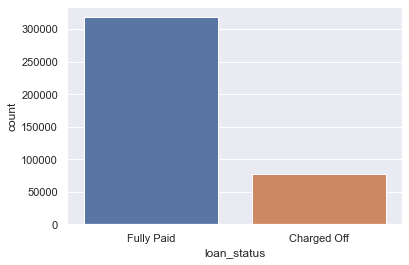

In [141]:
sns.countplot(x = "loan_status", data = df)

Text(0.5, 1.0, 'Loan Amount Distribution')

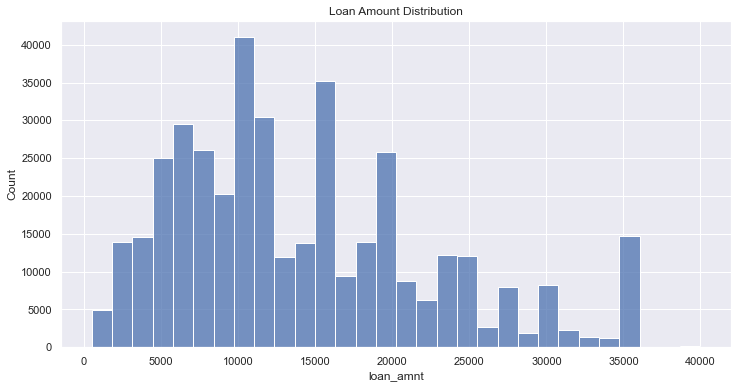

In [142]:
plt.figure(figsize =(12,6))
h1 = sns.histplot(data = df, x = "loan_amnt", bins = 30)
h1.set_title("Loan Amount Distribution")

In [143]:
corr = df.corr()

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Features')

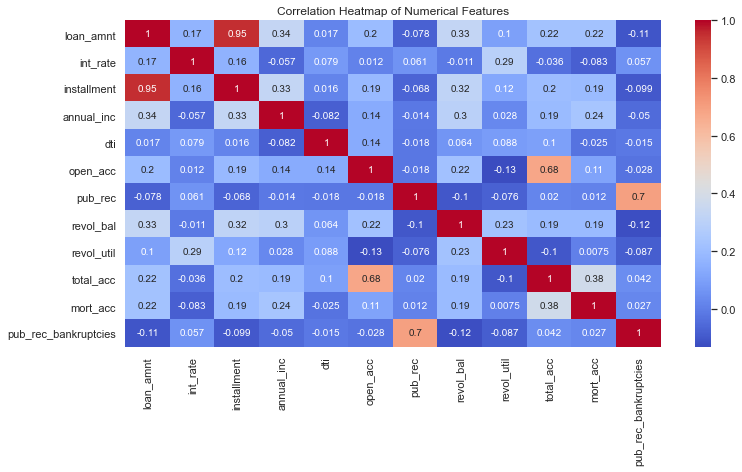

In [144]:
plt.figure(figsize =(12,6))
h1 = sns.heatmap(corr, annot = True, cmap = "coolwarm")
h1.set_title("Correlation Heatmap of Numerical Features")

Text(0.5, 1.0, 'Loan Amount vs Monthly Payment')

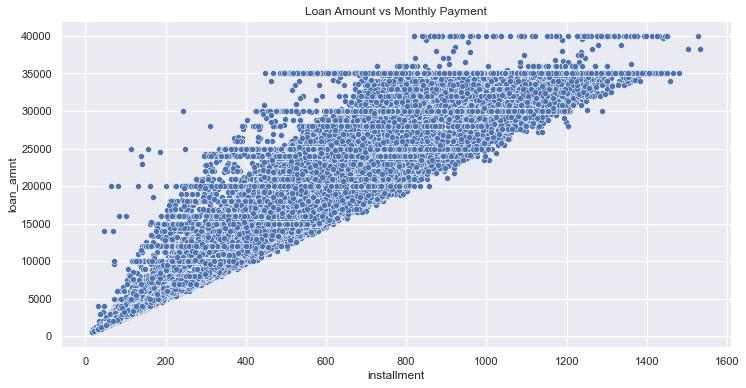

In [145]:
plt.figure(figsize =(12,6))
g = sns.scatterplot(data = df, x ="installment", y="loan_amnt"  )
g.set_title("Loan Amount vs Monthly Payment")

There appears to be some highly correlated features, specifically 95% between installment and loan_amount. This makes sense, given that installments represents the total monthly payment a given borrower is responsible for to service their loan. The higher the loan amount and interest, the higher the monthly payment will be. Let's examine the relationship between loan amount and loan status. 

In [146]:
df.groupby("loan_status")["loan_amnt"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


Text(0.5, 1.0, 'Loan Amount vs Status Boxplot')

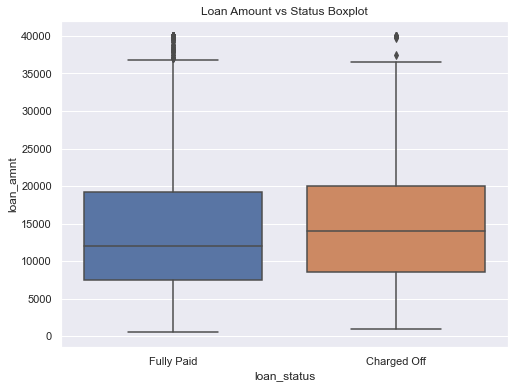

In [147]:
plt.figure(figsize =(8,6))
g = sns.boxplot(data = df, x ="loan_status", y="loan_amnt"  )
g.set_title("Loan Amount vs Status Boxplot")

Loan status and loan amount don't appear to be very divergent for either loan status category. 

There are two fields titled grade and subgrade. Generally speaking, grades represent the likelihood the initiating institutions believes the loan will default. This is demonstrated below with the countplot representing grade and the loan status.

Text(0.5, 1.0, 'Loan Grade vs Loan Status')

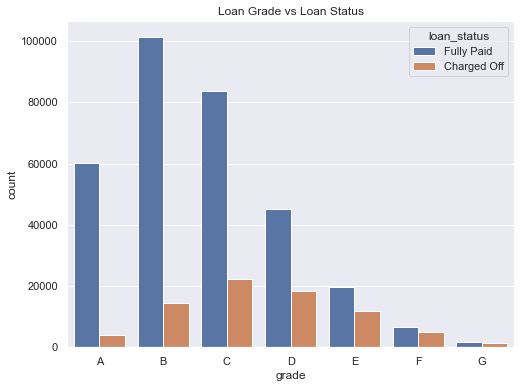

In [148]:
plt.figure(figsize =(8,6))
g = sns.countplot(data = df, x ="grade", hue="loan_status" , order = ["A", "B", "C", "D", "E", "F", "G"])
g.set_title("Loan Grade vs Loan Status")

We can utilize subgrade to get an understanding of the distribution in each traunch relative to the loan status. 

Text(0.5, 1.0, 'Loan Subgrade vs Loan Status')

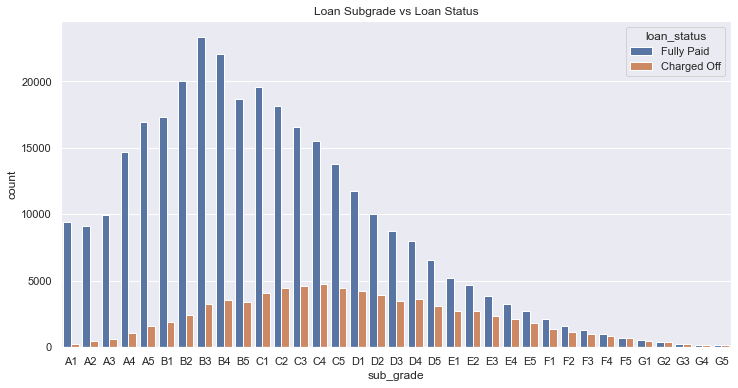

In [149]:
plt.figure(figsize =(12,6))
g = sns.countplot(data = df, x ="sub_grade", hue="loan_status" , order = ['A1','A2','A3','A4','A5','B1',
                                                                          'B2','B3','B4','B5','C1','C2','C3','C4',
                                                                          'C5','D1','D2','D3','D4','D5','E1','E2',
                                                                          'E3','E4','E5','F1','F2','F3','F4','F5',
                                                                          'G1','G2','G3','G4','G5'])
g.set_title("Loan Subgrade vs Loan Status")

As we can see, the probability of being fully repaid appears to be fuzzy in the C through E subgrades, and anything graded lower than that is relatively rare compared to the rest of the data set. With that in mind, I believe subgrade is capturing all the useful information that is included in grade. As such, I'll drop grade from the data set. 

Now I'd like to explore the correlation between our variable of interest, loan_status, and the numerical data we have. 

In [150]:
#representing loan status data as a boolean
df["loan_repaid"] = np.where(df["loan_status"] == "Fully Paid", 1, 0)

Text(0.5, 1.0, 'Numerical Fields Correlation with Loan Status')

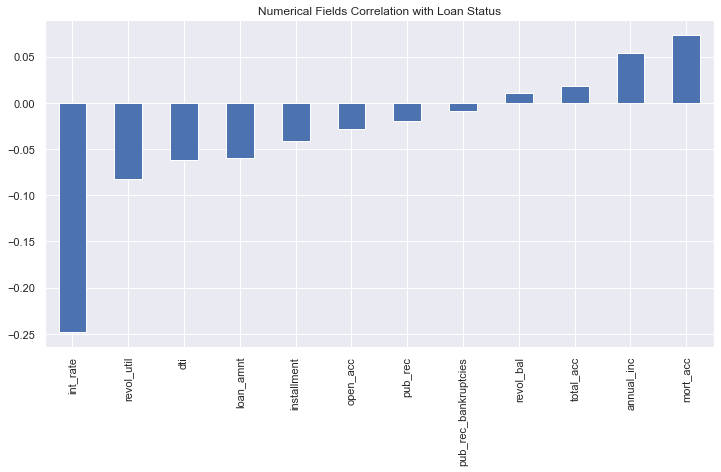

In [151]:
plt.figure(figsize = (12,6))
corr2 = df.corr()["loan_repaid"].sort_values().drop("loan_repaid")
g = corr2.plot.bar(y = "loan_repaid")
g.set_title("Numerical Fields Correlation with Loan Status")

It appears that int_rate is the strongest correlation with loan status in this data set, with a negative 25%. This follows traditional logic in that loan originators typically charge higher interest rates to those they beleive will default on their debt.

# Data Preprocessing and Feature Construction  

In this section I identify missing values, drop superflous variables, and utilize one-hot-encoding to generate dummies for the categorical variables. 

In [152]:
100* df.isnull().sum()/len(df)

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
loan_repaid             0.000000
dtype: float64

In [153]:
df["emp_title"].nunique()

173105

The title column represents the job title for the loan applicant. With over 173k unique titles, it isn't practical to create dummy variables with my resource constraints. On top of that, employment length may be a better way to relate employment history to the probability of default. I'll explore the relationship between employment length and loan status below. 

In [154]:
df = df.drop("emp_title", axis = 1)

In [155]:
ordered = [ '< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', 
           '7 years', '8 years', '9 years','10+ years']

Text(0.5, 1.0, 'Employment Length by Loan Status')

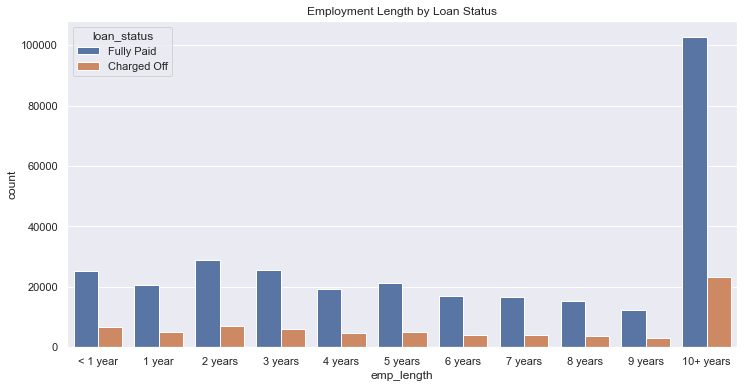

In [156]:
plt.figure(figsize =(12,6))
g = sns.countplot(data = df, x ="emp_length", hue="loan_status" , order = ordered)
g.set_title("Employment Length by Loan Status")

The above plot seems promising, but may lead one to prematurely conclude that we should include the emp_length variable. However, we need to explore the relative variation of loan status for each emp_length category. 

In [157]:
emp_co = df[df["loan_status"] == "Charged Off"].groupby("emp_length").count()["loan_status"]
emp_fp = df[df["loan_status"] == "Fully Paid"].groupby("emp_length").count()["loan_status"]
emp_co/emp_fp

emp_length
1 year       0.248649
10+ years    0.225770
2 years      0.239560
3 years      0.242593
4 years      0.238213
5 years      0.237911
6 years      0.233341
7 years      0.241887
8 years      0.249625
9 years      0.250735
< 1 year     0.260830
Name: loan_status, dtype: float64

The above calculation captures the percent of defaults ( *loan status == "Charged Off"* ) within each employment length category. By exploring variability of loan status between each category, we can see that across all categories there appears to be approximately 22% to 25% of loans that have defaulted regardless of how long someone has been employed. This would indicate that it's likely not a reliable metric for predicting loan status and I drop it from my analysis. 

In [158]:
df = df.drop("emp_length", axis = 1)

In [159]:
print("Title")
print(df["title"].head(10))
print("\n")
print("Purpose")
print(df["purpose"].head(10))

Title
0                   Vacation
1         Debt consolidation
2    Credit card refinancing
3    Credit card refinancing
4      Credit Card Refinance
5         Debt consolidation
6           Home improvement
7       No More Credit Cards
8         Debt consolidation
9         Debt Consolidation
Name: title, dtype: object


Purpose
0              vacation
1    debt_consolidation
2           credit_card
3           credit_card
4           credit_card
5    debt_consolidation
6      home_improvement
7           credit_card
8    debt_consolidation
9    debt_consolidation
Name: purpose, dtype: object


In [160]:
df = df.drop(["title", "grade", "issue_d"], axis = 1)

In [161]:
total_acc_avg = df.groupby('total_acc').mean()['mort_acc']

Here I'm coping with the missing values in mort_acc. As shown above that amounts to approximately 10% of the values. I have taken the average value of mort_acc and will replace the missing values with the average. I'm doing this based on the positive correlation that exists between the 

In [162]:
def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc

In [163]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [164]:
## Verfication_stats, appliication_type, intial_list_status, purpose dummy variables
df = df.dropna()
dummies = pd.get_dummies(df[['verification_status', 'application_type','initial_list_status','purpose' ]],
                         drop_first=True)
df = df.drop(['verification_status', 'application_type','initial_list_status','purpose'],axis=1)
df = pd.concat([df,dummies],axis=1)

In [165]:
#combining "NONE" and "ANY" home_ownership categories, generating dummies

df['home_ownership']=df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')

dummies = pd.get_dummies(df['home_ownership'],drop_first=True)
df = df.drop('home_ownership',axis=1)
df = pd.concat([df,dummies],axis=1)

In [166]:
# year extraction and dropping earliest_cr_line

df['earliest_cr_year'] = df['earliest_cr_line'].apply(lambda date:int(date[-4:]))
df = df.drop('earliest_cr_line',axis=1)

In [167]:
#zip code extraction and dummy variable

df['zip_code'] = df['address'].apply(lambda address:address[-5:])

dummies = pd.get_dummies(df['zip_code'],drop_first=True)
df = df.drop(['zip_code','address'],axis=1)
df = pd.concat([df,dummies],axis=1)

In [168]:
#subgrade dummies 

subgrade_dummies = pd.get_dummies(df['sub_grade'],drop_first=True)
df = pd.concat([df.drop('sub_grade',axis=1),subgrade_dummies],axis=1)

In [169]:
#term dummies

term_dummies = pd.get_dummies(df['term'],drop_first=True)
df = pd.concat([df.drop('term',axis=1),term_dummies],axis=1)

In [170]:
#dropping loan status, rely on loan repaid for model estimation

df = df.drop("loan_status", axis = 1 )

# Data Cleaning Summary:

The title and purpose columns are probably duplicates. Between that likelihood, and the fact that title has some missing values I've decided to drop the title column. 

Revol_util and pub_rec_bankruptcies both have less than 1% of missing values. As such I've decided to drop rows that are missing those values from the data set. 

Issue_d represents the issue date for a given loan in this dataset. Conceptually speaking, if the following model were to be used to predict loan default, the issue date would obviously not be available for new loans. Because of that I have dropped issue_d from the data set. 

The address field seems to contain zip codes. With that in mind, I extracted the zip code and generated dummy variables to be included in my model. 

Finally, the other work in this section was converting categorical variables into dummies, combining some categories and coping with a date/timeframe field earliest_cr_year. I extracted the year from earliest_cr_year and then dropped the original variable.

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395219 entries, 0 to 396029
Data columns (total 79 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            395219 non-null  float64
 1   int_rate                             395219 non-null  float64
 2   installment                          395219 non-null  float64
 3   annual_inc                           395219 non-null  float64
 4   dti                                  395219 non-null  float64
 5   open_acc                             395219 non-null  float64
 6   pub_rec                              395219 non-null  float64
 7   revol_bal                            395219 non-null  float64
 8   revol_util                           395219 non-null  float64
 9   total_acc                            395219 non-null  float64
 10  mort_acc                             395219 non-null  float64
 11  pub_rec_bankr

# Sample for training  

My laptop is relatively constrained by the hardware. To shorten training times I take a random sample of the cleaned data before my train test split. If the system you're replicating my work on isn't constrained, I'd reccomend commenting out the following cells and running the model with the full data set. 

In [172]:
#df_sample = df.sample(frac = .25, random_state = 1234)
#print(len(df_sample))

# Model Estimation



## Train Test Split

In [173]:
from sklearn.model_selection import train_test_split

In [174]:
X = df.drop("loan_repaid", axis = 1).values
y = df["loan_repaid"].values

## Normalizing the data

In [201]:
from sklearn.preprocessing import MinMaxScaler

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [203]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [204]:
#importing Tensorflow and Keras 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [205]:
#defining layers of NN 
model = Sequential()

# input 
model.add(Dense(78, activation = "relu"))
model.add(Dropout(.2))

# hidden 
model.add(Dense(39, activation = "relu"))
model.add(Dropout(.2))

# hidden 
model.add(Dense(19, activation = "relu"))
model.add(Dropout(.2))

# ouput
model.add(Dense(1, activation = "sigmoid"))


# compiling 
model.compile(loss = "binary_crossentropy", optimizer = "adam")

In [206]:
#Fitting the model 
model.fit(x=X_train, 
          y=y_train, 
          epochs=25,
          batch_size=256,
          validation_data=(X_test, y_test) 
          )

Epoch 1/25
1236/1236 [==============================] - 2s 1ms/step - loss: 0.3018 - val_loss: 0.2713
Epoch 2/25
1236/1236 [==============================] - 2s 1ms/step - loss: 0.2654 - val_loss: 0.2730
Epoch 3/25
1236/1236 [==============================] - 2s 1ms/step - loss: 0.2632 - val_loss: 0.2790
Epoch 4/25
1236/1236 [==============================] - 2s 1ms/step - loss: 0.2619 - val_loss: 0.2723
Epoch 5/25
1236/1236 [==============================] - 2s 1ms/step - loss: 0.2611 - val_loss: 0.2767
Epoch 6/25
1236/1236 [==============================] - 2s 1ms/step - loss: 0.2605 - val_loss: 0.2897
Epoch 7/25
1236/1236 [==============================] - 2s 1ms/step - loss: 0.2599 - val_loss: 0.2830
Epoch 8/25
1236/1236 [==============================] - 2s 1ms/step - loss: 0.2594 - val_loss: 0.2862
Epoch 9/25
1236/1236 [==============================] - 2s 1ms/step - loss: 0.2593 - val_loss: 0.2938
Epoch 10/25
1236/1236 [==============================] - 2s 1ms/step - loss: 0.259

In [207]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

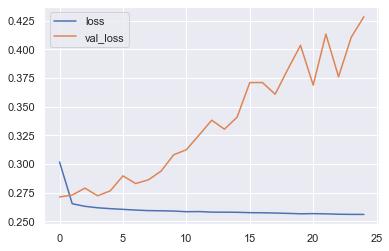

In [208]:
losses[["loss", "val_loss"]].plot()

In [209]:
from sklearn.metrics import classification_report,confusion_matrix

In [210]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

In [211]:
print("Confusion Matrix")
print(confusion_matrix(y_test,predictions))
print("\n")

print("Classification Report")
print(classification_report(y_test,predictions))

Confusion Matrix
[[12965  2693]
 [17446 45940]]


Classification Report
              precision    recall  f1-score   support

           0       0.43      0.83      0.56     15658
           1       0.94      0.72      0.82     63386

    accuracy                           0.75     79044
   macro avg       0.69      0.78      0.69     79044
weighted avg       0.84      0.75      0.77     79044



# Discussion  

With an overall accuracy of 75%, this model is performing at a middling level. That said, it has a precision of 94% in predicting whether a loan gets repaid. With that in mind how should a loan originator use its output in their day to day workflow? Additionally, how could we improve the models performance over time and begin to account for market conditions and incorporate real time data? 

As with any model, loan originators should view this as a tool in a larger set of information to inform their decision when it comes to issuing credit. The model has a 94% precision in predicting which borrowers will pay back their loan, but it achieves that in a mildly bias way. In one sense, the model is highly conservative in it's predictions. If a loan originator were to rely only on it's output, they'd be missing opportunities that could drive additional growth in their portfolios. Unfortunately, there is little that can be intrepetted out of this model to help identify features of interest. That said, it may be worth while to add additional models and metrics into a report with the output from this model to shed some light on those questions. 

As with most technology, the best way to improve is to iterate. Improving on this model should begin focusing on putting it into production and seeing how it performs in the real world. Then we should begin constructing real time features, that could include number of payments remaining, number of payments made, and a boolean highlighting whether or not the borrower made the most recent payments. There is also nothing to represent credit score in this data. We should also explore adding things like regional unemployment rates, salary information, and education into the model. I believe if we did that we could improve performance given time.
